In [2]:
# Imports
import sys
import os
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import cumulative_trapezoid
from scipy.optimize import curve_fit


# plt.rcParams.update({"font.size": 18})
sys.path.insert(0, os.path.abspath("."))
sys.path.append(os.path.abspath("../../../"))

import desc.io
from desc.equilibrium.coords import get_rtz_grid
from desc.grid import Grid
from desc.backend import jnp

In [165]:
# Load heliotron equilibrium
eq_fam_helio = desc.io.load("/home/jjfrybes/DESC/docs/notebooks/tutorials/input.HELIOTRON_output.h5")
eq_helio = eq_fam_helio[-1]

# Load w7x high mirror equilibrium
eq_fam_w7x = desc.io.load("/home/jjfrybes/DESC/docs/notebooks/tutorials/w7x_output.h5")
eq_w7x = eq_fam_w7x[-1]

# Load precise QA equilibrium
eq_precise_QA = desc.io.load("/home/jjfrybes/DESC/docs/notebooks/tutorials/DESC_from_NAE_precise_QA_output.h5")

# Load NCSX equilibrium
eq_fam_NCSX = desc.io.load("/home/jjfrybes/DESC/desc/examples/NCSX_output.h5")
eq_NCSX = eq_fam_NCSX[-1]

eq_fam_HSX = desc.io.load("/home/jjfrybes/DESC/desc/examples/HSX_output.h5")
eq_HSX = eq_fam_HSX[-1]

eq_fam_w7x2 = desc.io.load("/home/jjfrybes/DESC/desc/examples/W7-X_output.h5")
eq_w7x2 = eq_fam_w7x2[-1]

In [397]:
rho = np.array(0.5)
alpha = 0
# Number of toroidal transits of the field line
nturns = 2
# Number of point along a field line
N0 = nturns * 200
zeta = np.linspace(0, 2*nturns*np.pi, N0)

grid = Grid.create_meshgrid(
        [rho, alpha, zeta], coordinates="raz", period=(np.inf, 2 * np.pi, np.inf)
)

In [391]:
curv = get_value(eq_helio,"cvdrift",grid)
a = get_value(eq_helio,"a",grid)

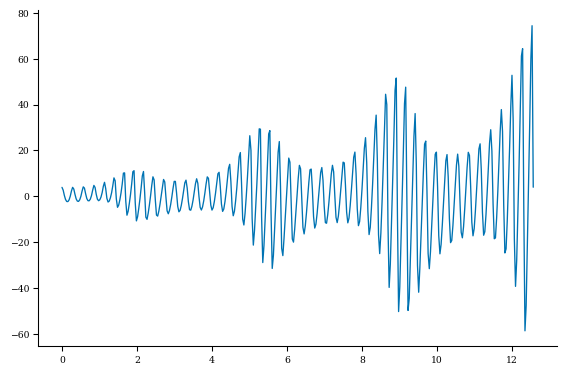

In [392]:
plt.figure()
plt.plot(grid.nodes[:,2],-a**2*curv)

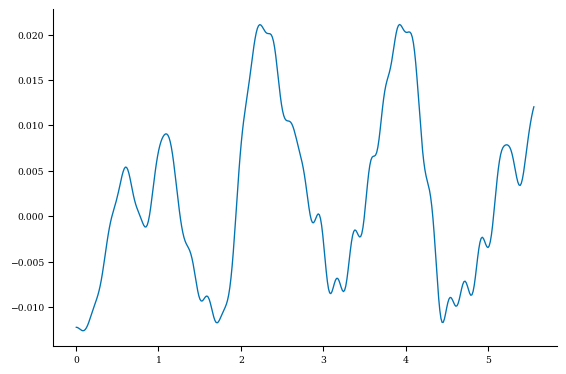

In [385]:
plt.figure()
plt.plot(grid2.nodes[0:400,2],-a2**2*drift_curv[0:400])

In [350]:
# Function to get value of a parameter directly
def get_value(eq,name,grid):
    return eq.compute(name,grid=grid)[name]

def get_arc_length (diff_l,grid):
    # Integrate differential length along field line with respect to zeta
    return cumulative_trapezoid(diff_l,grid.nodes[:,2],initial=0)

# Function to get the straight field line coordinate system
def get_field_line_grid(eq,rho=0.5,alpha=0,n_turns = 4,n_points = 1000):
    # Get initial grid to get iota profile TODO find if easier way to find iota, also takes the longest
    initial_grid = get_rtz_grid(
        eq,
        np.array(np.sqrt(rho)),
        np.array(alpha),
        np.linspace(0,np.pi/4,100),
        coordinates="raz",
        period=(np.inf,2*np.pi,np.inf)
    )
    iota = np.abs(get_value(eq,"iota",initial_grid)[1])
    NFP = eq.NFP
    n_tor = n_turns/(iota*NFP)
    good_grid = get_rtz_grid(
        eq,
        np.array(np.sqrt(rho)),
        np.array(alpha),
        np.linspace(0,2*n_tor*np.pi,n_points),
        coordinates="raz",
        period=(np.inf,2*np.pi,np.inf),
    )
    return good_grid


# Function for plotting the drift curvature
def plot_drift_curv(eq,grid,drift_curv=None,diff_l=None,l=None,a=None):
    
    # Compute all necessary quantities if not provided
    if drift_curv is None:
        drift_curv = get_value(eq,"cvdrift",grid)

    if l is not None :
        arc_length_vals = l
    else : 
        if diff_l is None:
            diff_l = get_value(eq,"|e_zeta|r,a|",grid)
        arc_length_vals = get_arc_length(diff_l,grid)

    if a is None:
        a = get_value(eq,"a",grid)
    
    plt.figure()
    plt.plot(arc_length_vals,-drift_curv)
    plt.xlabel("l")
    plt.ylabel(r"$-K_D$ [1/Tm]")
    


In [345]:
# Quadratic fitting function for Kd peaks (bad curvature)
def Kd_quadratic(l, Reff_n, ln):
    lc = (l[0]+l[-1])/2
    return 1/Reff_n * (1 - (l - lc)**2 / ln**2)

# Quadratic fiiting function for Kd valleys (good curvature)
def Kd_quadratic_(l, Reff_n, ln):
    lc = (l[0]+l[-1])/2
    return -1/Reff_n * (1 - (l - lc)**2 / ln**2)

def fit_drift_peaks(l, Kd, a_grad_alpha_norm):
    peaks = []
    fits = []
    values = []
    
    # Find indices where Kd changes sign (crosses zero)
    zero_crossings = np.where(np.diff(np.sign(Kd)))[0]
    
    # Initialize lists to store valid peak intervals
    peak_indices = []
    
    len_thres = 40 
    # Loop over zero crossing pairs to check if it's a peak or a valley
    for i in range(0, len(zero_crossings)-1):
        l_min_idx = zero_crossings[i]
        l_max_idx = zero_crossings[i + 1]
        len_peak = l_max_idx-l_min_idx

        # # Skip if there's insufficient data points
        if len_peak < len_thres:
            continue  
        
        # Check the midpoint value of Kd
        mid_idx = (l_min_idx + l_max_idx) // 2
        if Kd[mid_idx] > 0:  # Keep the range if it's a peak (Kd is positive)
            peak_indices.append((l_min_idx, l_max_idx, mid_idx))
        else : 
            continue
        
        # Update threshold length depending on previous well
        len_thres = int(0.6*len_peak)

    p0 = [1,1]
    # Loop through valid peak indices and perform fitting
    for l_min_idx, l_max_idx, mid_idx in peak_indices:
        # Extract the arc length and Kd values within the peak
        l_peak = l[l_min_idx:l_max_idx+1]
        Kd_peak = Kd[l_min_idx:l_max_idx+1]     
        
        # Fit the quadratic curve to the peak
        popt,_ = curve_fit(Kd_quadratic,l_peak,Kd_peak,p0=p0)

        R_eff = popt[0]
        L_par = l[l_max_idx] - l[l_min_idx]
        
        # Store the peak data and fitting parameters
        peaks.append((l_peak, Kd_peak))
        fits.append(popt)
        values.append([R_eff,L_par,a_grad_alpha_norm[mid_idx]])
        p0 = popt # TODO find better way of deinining initial guess

    data = {
        "peaks" :       peaks,
        "fits"  :       fits,
        "values":       values,
    }
    return data

def plot_drift_fits(l,drift_curv,data):
    
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(l,-drift_curv,label=r'$-K_D$')

    num_fits = len(data["fits"])

    # Create a colormap
    colormap = plt.colormaps['viridis']

    # Generate colors from the colormap
    colors = [colormap(i / num_fits) for i in range(num_fits)]
    
    for (l_peak, pos_Kd_peak), (Reff_n, ln), (_,L_par,_), color in zip(data["peaks"], data["fits"], data["values"], colors):
        plt.plot(l_peak, -Kd_quadratic(l_peak, Reff_n, ln), '--', label=f'Fit: $R_{{eff}}={Reff_n:.2f}$, $L_\\parallel={L_par:.2f}$',color=color, linewidth = 1.5)

    ax.set_xlabel(r'$l$', fontsize=14)
    ax.set_ylabel(r'$-K_D$ [1/Tm]', fontsize=14)
    ax.set_title('Curvature Drift ($-K_D$) and Quadratic Fits', fontsize=16)
    ax.grid=True
    # ax.legend(fontsize=12, loc='center left', bbox_to_anchor=(1, 0.5))  # Move the legend outside
    ax.legend(fontsize=12, loc='upper left')  # Move the legend outside


    plt.tight_layout(rect=[0, 0, 0.85, 1])
    plt.show()


In [137]:
def get_everything (eq,rho=0.5,alpha=0,n_turns=4,n_points=1000,plot=True):

    # Create the grid
    grid = get_field_line_grid(eq,rho=rho,alpha=alpha,n_turns=n_turns,n_points=n_points)

    # Get all the necessary values
    drift_curv = get_value(eq,"cvdrift",grid)
    a = get_value(eq,"a",grid)
    a_grad_alpha_3d = get_value(eq,"grad(alpha)",grid)
    a_grad_alpha_norm = jnp.sqrt(dot(a_grad_alpha_3d,a_grad_alpha_3d))

    # Multiply drift curvature by a^2 as in initial article
    drift_curv = drift_curv*a*a
    diff_l = get_value(eq,"|e_zeta|r,a|",grid)

    # Integrate the differentail length
    l = get_arc_length(diff_l,grid)

    # Get peaks and fits
    data = fit_drift_peaks(l,drift_curv,a_grad_alpha_norm)

    # Plot everything
    if plot :
        plot_drift_fits(l,drift_curv,data)

    return (grid,drift_curv,a,l,data)



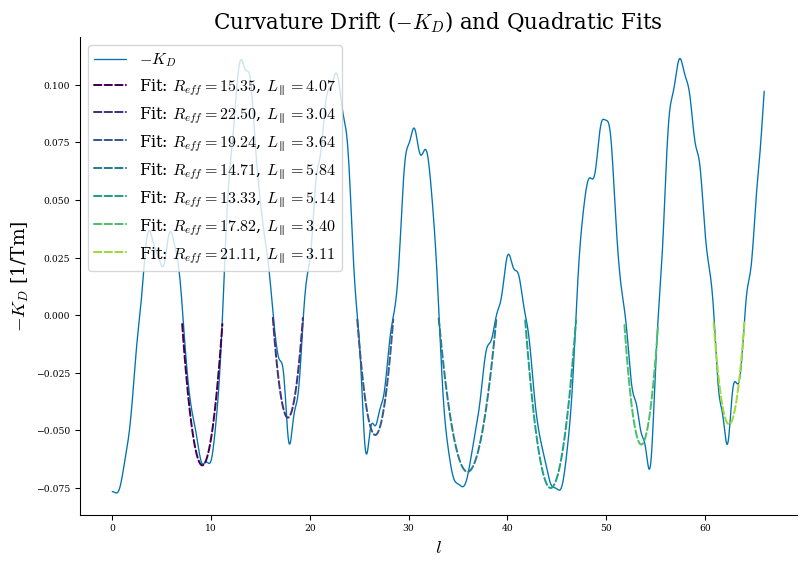

In [120]:
grid,drift_curv,a,l,data = get_everything(eq_w7x,n_turns=8);

In [344]:
def fit_all_drift_peaks(l, Kd, a_grad_alpha_norm):

    # Save all values for bad curvature
    peaks_bad = []
    fits_bad = []
    values_bad = []
    
    # Save all values for good curvature
    peaks_good = []
    fits_good = []
    values_good = []
    
    # Find indices where Kd changes sign (crosses zero)
    zero_crossings = np.where(np.diff(np.sign(Kd)))[0]
    
    # Initialize lists to store valid peak intervals
    bad_peak_indices = []
    good_peak_indices = []

    len_thres = 40 
    # Loop over zero crossing pairs to check if it's a peak or a valley
    for i in range(0, len(zero_crossings)-1):
        l_min_idx = zero_crossings[i]
        l_max_idx = zero_crossings[i + 1]
        len_peak = l_max_idx-l_min_idx

        # # Skip if there's insufficient data points
        if len_peak < len_thres:
            continue  

        # Check the midpoint value of Kd
        mid_idx = (l_min_idx + l_max_idx) // 2
        if Kd[mid_idx] > 0:  # Keep the range if it's a peak (Kd is positive)
            bad_peak_indices.append((l_min_idx, l_max_idx, mid_idx))
        else:
            good_peak_indices.append((l_min_idx, l_max_idx, mid_idx))
        
        len_thres = int(0.6*len_peak)

    def get_fits(peak_indices,bad_curv = True):
        # Define variables for storing the data
        peaks = []
        fits = []
        values = []

        p0 = [1,1]
        # Loop through valid peak indices and perform fitting
        for l_min_idx, l_max_idx, mid_idx in peak_indices:
            # Extract the arc length and Kd values within the peak
            l_peak = l[l_min_idx:l_max_idx+1]
            Kd_peak = Kd[l_min_idx:l_max_idx+1]   
            
            # Fit the quadratic curve to the peak
            if bad_curv:
                popt,_ = curve_fit(Kd_quadratic,l_peak,Kd_peak,p0=p0)
            else :
                popt,_ = curve_fit(Kd_quadratic_,l_peak,Kd_peak,p0=p0)
                
            R_eff = popt[0]
            L_par = l[l_max_idx] - l[l_min_idx]
            peaks.append((l_peak, Kd_peak))
            fits.append(popt)
            values.append([R_eff,L_par,a_grad_alpha_norm[mid_idx]])
            p0 = popt 
        return peaks,fits,values
    
    peaks_bad,fits_bad,values_bad = get_fits(bad_peak_indices,bad_curv=True)
    peaks_good,fits_good,values_good = get_fits(good_peak_indices,bad_curv=False)  
    data_bad = {
        "extrema" : peaks_bad,
        "fits"    : fits_bad,
        "values"  : values_bad  
    }  
    data_good = {
        "extrema" : peaks_good,
        "fits"    : fits_good,
        "values"  : values_good  
    }  
    
    return data_bad,data_good

In [39]:
# def plot_all_drift_fits(l,drift_curv,bad_peaks,bad_fits,bad_values,good_peaks,good_fits,good_values):
def plot_all_drift_fits(l,drift_curv,data_bad,data_good):
    
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(l,-drift_curv,label=r'$-K_D$')
    
    for (l_peak, pos_Kd_peak), (Reff_n, ln), (_,L_par) in zip(data_bad["extrema"],data_bad["fits"],data_bad["values"]):
        plt.plot(l_peak, -Kd_quadratic(l_peak, Reff_n, ln), '--', label=f'Fit: $R_{{eff}}={Reff_n:.2f}$, $L_\\parallel={L_par:.2f}$', linewidth = 1.5)

    for (l_peak, pos_Kd_peak), (Reff_n, ln), (_,L_par) in zip(data_good["extrema"],data_good["fits"],data_good["values"]):
            plt.plot(l_peak, Kd_quadratic(l_peak, Reff_n, ln), '--', label=f'Fit: $R_{{good}}={Reff_n:.2f}$, $L_w={L_par:.2f}$', linewidth = 1.5)

    ax.set_xlabel(r'$l$', fontsize=14)
    ax.set_ylabel(r'$-K_D$ [1/Tm]', fontsize=14)
    ax.set_title('Curvature Drift ($-K_D$) and Quadratic Fits', fontsize=16)
    ax.grid=True
    ax.legend(fontsize=12, loc='center left', bbox_to_anchor=(1, 0.5))  # Move the legend outside

    plt.tight_layout(rect=[0, 0, 0.85, 1])
    plt.show()

In [155]:
def get_all_everything (eq,rho=0.5,alpha=0,n_turns=4,n_points=1000,plot=False):

    # Create the grid
    grid = get_field_line_grid(eq,rho=rho,alpha=alpha,n_turns=n_turns,n_points=n_points)

    # Get all the necessary values
    drift_curv = get_value(eq,"cvdrift",grid)
    a = get_value(eq,"a",grid)
    a_grad_alpha_3d = get_value(eq,"grad(alpha)",grid)
    a_grad_alpha_norm = jnp.sqrt(dot(a_grad_alpha_3d,a_grad_alpha_3d))

    drift_curv = drift_curv*a*a
    diff_l = get_value(eq,"|e_zeta|r,a|",grid)

    # Integrate the differentail length
    l = get_arc_length(diff_l,grid)

    # Get peaks and fits
    data_bad,data_good = fit_all_drift_peaks(l, drift_curv,a_grad_alpha_norm)

    # Plot everything
    if plot :
        plot_all_drift_fits(l,drift_curv,data_bad,data_good)

    return (grid,drift_curv,a,a_grad_alpha_norm,l,data_bad,data_good)

In [37]:
def calculate_Ls (eq,grid):
    shear = get_value(eq,"shear",grid)[1]
    q = get_value(eq,"q",grid)[1]
    R = get_value(eq,"R0",grid)
    return np.abs(q*R/shear)

def Theta_function(x):
    # Define Heaviside step function
    return x*np.where(x >= 0, 1, 0)

def check_peaks(peaks_bad,peaks_good):
    # Function that checks if first extremum is a peak (bad curvature) 
    # or valley (good curvature) in the curvature drift
    l_bad = peaks_bad[0][0][0]
    l_good = peaks_good[0][0][0]
    if l_bad<l_good:
        first = "bad"
    else :
        first = "good"
    return first

def zero_div(x):
    if x==0:
        result = np.inf
    else:
        result = 1/x
    return result

In [74]:
def get_parallel_correlation_lengths (values_bad,values_good,L_s,first,type="next"):
    # Example values (replace with your actual calculated values)
    L_parallel_inv = []
    total_peaks = len(values_bad)+len(values_good)

    # If we want to give a random start
    if total_peaks%2 == 1 :
        if first == "bad" and type == "next":
            values_good = values_good[:-1]
        elif first == "bad" and type == "previous":
            values_bad = values_bad[1:]
        elif first == "good" and type == "next":
            values_good = values_good[1:]
        elif first == "good" and type == "previous":
            values_bad = values_bad[:-1]
    else :
        if first == "bad" and type == "previous":
            values_bad = values_bad[1:]
            values_good = values_good[:-1]
        elif first == "good" and type == "next":
            values_good = values_good[1:]
            values_bad = values_bad[:-1]
    
    for (R_eff,_),(R_good,L_w) in zip(values_bad,values_good):          

        # Calculate p1 and p2
        p1 = R_eff / L_w - 0.20
        p2 = R_eff / L_s - 0.15

        # Calculate 1/L_parallel
        L_par_inv = (1 / R_eff) * Theta_function(p1) * (Theta_function(R_eff / R_good - 1) / (R_eff / R_good + 1))*0.5*(1 + np.tanh(20 * p2))
        L_parallel_inv.append(L_par_inv)
    return L_parallel_inv



In [33]:
def plot_coeffs(data_bad):
    values = data_bad["values"]
    R_eff = [row[0] for row in values]
    L_par = [row[1] for row in values]
    plt.figure()
    plt.plot(R_eff)
    plt.xlabel("Drift well number")
    plt.ylabel(r"$R_{eff}$")
    
    plt.figure()
    plt.plot(L_par)
    plt.xlabel("Drift well number")
    plt.ylabel(r"$L_{\parallel}$")

In [212]:
def calculate_critical_gradient(a,R_eff,L_par):
    return 2.66*(a/R_eff+8.00*a/L_par)

def F(b):
    if b < 0.755:
        return 2.84 + 4.926 * b
    else:
        return 0.0371 + 7.51 * np.sqrt(b)

def calculate_critical_gradient2(a,a_grad_alpha,R_eff,L_par):
    return a/R_eff * F((np.pi*np.abs(a_grad_alpha)*R_eff/L_par)**2)

def get_critical_gradients(a,vals,method=1,plot=True):
    critical_gradients = []
    for (R_eff,L_par,a_grad_alpha) in vals : 
        if method == 1: 
            critical_gradients.append(calculate_critical_gradient(a,R_eff,L_par))
        elif method == 2:
            critical_gradients.append(calculate_critical_gradient2(a,a_grad_alpha,R_eff,L_par))
    if plot :
        plt.figure()
        plt.plot(critical_gradients)
        plt.ylabel(r'$a/L_T$')
        plt.title(f"Critical gradient calculated by method {method}")

        # Find the minimum value and its index
        min_value = np.min(critical_gradients)
        min_index = np.argmin(critical_gradients)

        # Annotate the minimum value on the plot
        plt.annotate(f'Min: {min_value:.2f}', 
                    xy=(min_index, min_value), 
                    xytext=(min_index + 1, min_value + 0.5),  # Adjust text position
                    arrowprops=dict(facecolor='black', arrowstyle='->'))
        
        plt.show

    return critical_gradients

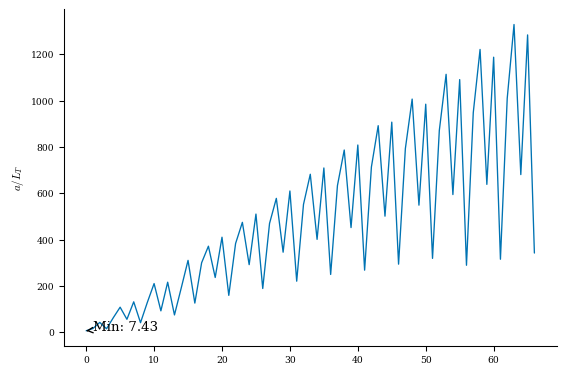

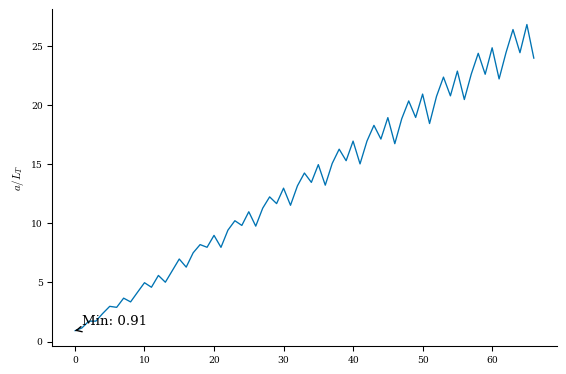

In [142]:
grid,drift_curv,a,l,data = get_everything(eq_NCSX,n_turns=200,n_points=20000,plot=False);
get_critical_gradients(a,data["values"],method=2);
get_critical_gradients(a,data["values"],method=1);

In [406]:
def critical_gradient_analysis(eq,n_turns=50,n_points=5000):
    # Retrieve data
    grid,drift_curv,a,a_grad_alpha_norm,l,data_bad,data_good = get_all_everything(eq,n_turns=n_turns,n_points=n_points)
    # Select a shorter length of data for showing the fits
    short_fit_lim = int(15*n_points/n_turns)
    data_short = fit_drift_peaks(l[0:short_fit_lim], drift_curv[0:short_fit_lim], a_grad_alpha_norm[0:short_fit_lim])
    # Plot the fits
    plot_drift_fits(l[0:short_fit_lim],drift_curv[0:short_fit_lim],data_short)
    # Plot the curvature drift
    plot_drift_curv(eq,grid,drift_curv=drift_curv,l=l,a=a)
    # Plot the evolution of R_eff and L_par with respect to the drift well number
    plot_coeffs(data_bad)
    # Get the critical gradients
    critical_gradients1 = get_critical_gradients(a,data_bad["values"])
    critical_gradients2 = get_critical_gradients(a,data_bad["values"],method=2)
    critical_gradients = {
        "critical_gradients1" : critical_gradients1,
        "critical_gradients2" : critical_gradients2
    }

    # Return all interesting quantities
    return grid,drift_curv,a,l,data_bad,data_good,critical_gradients

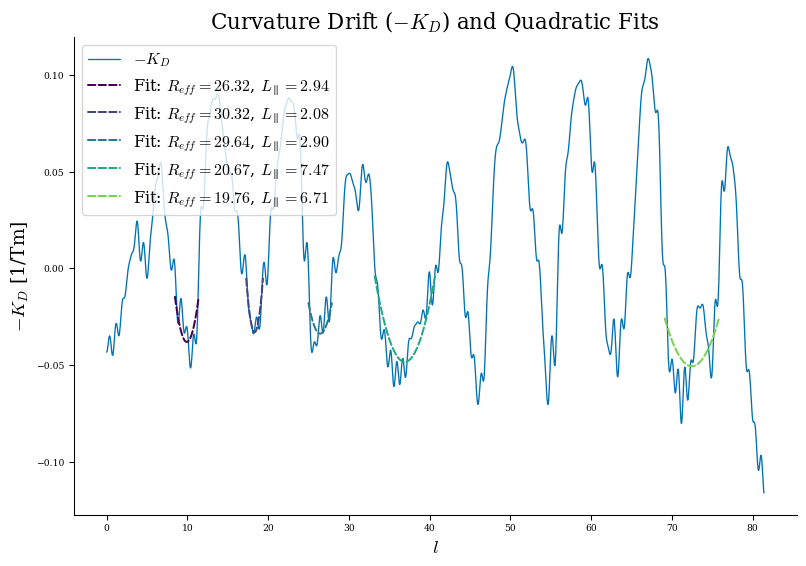

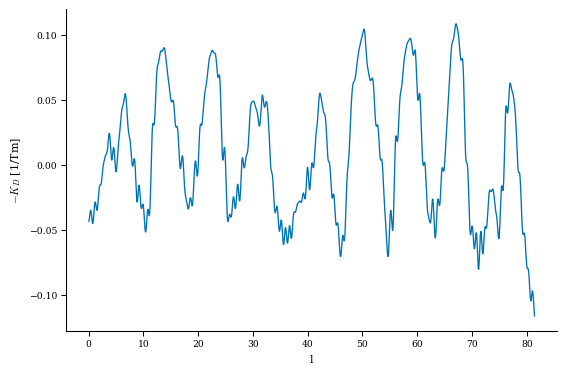

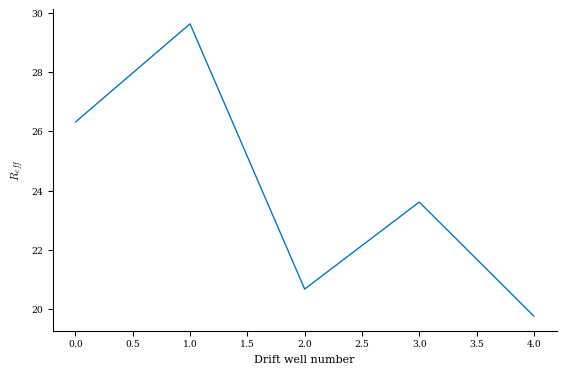

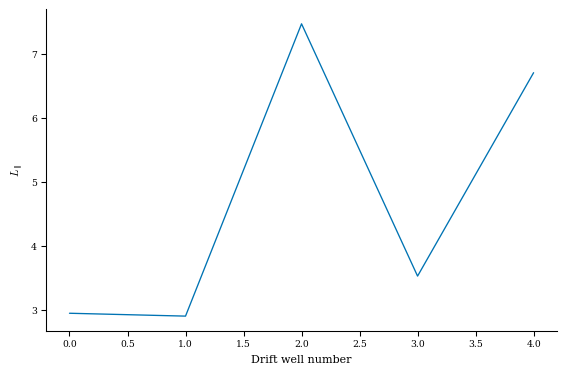

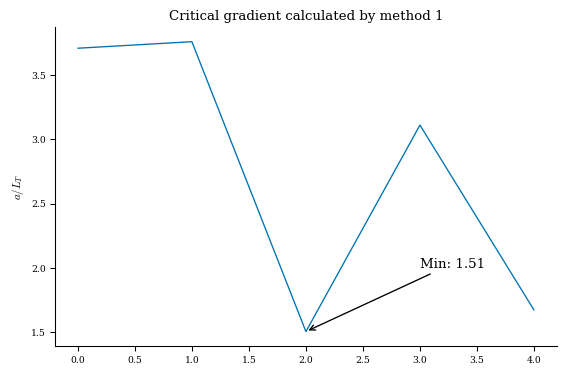

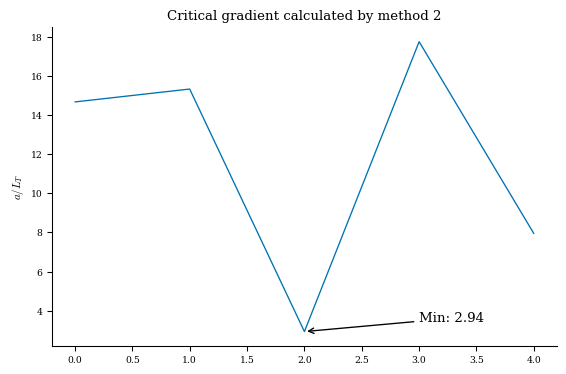

In [409]:
grid,drift_curv,a,l,data_bad,data_good,critical_gradients = critical_gradient_analysis(eq_w7x2,n_turns=10,n_points=2000)

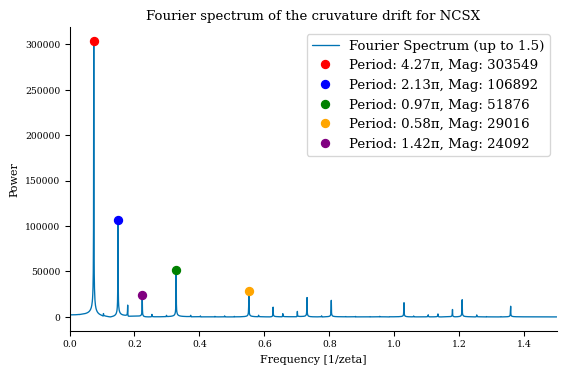

Top 5 Dominant frequencies: [0.07461481 0.14922962 0.32830517 0.5521496  0.22384443]
Associated periods: [4.26604156 2.13302078 0.9695549  0.5764921  1.42201385]


In [282]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq
from scipy.signal import find_peaks

machine = "NCSX"

zeta = grid.nodes[:,-1]

# Number of sample points and sample spacing
N = len(drift_curv)
T = np.mean(np.diff(zeta))  # Sample spacing, assuming l is evenly spaced

# Compute the Fast Fourier Transform (FFT)
fft_values = fft(drift_curv)
fft_frequencies = fftfreq(N, T)[:N//2]  # Positive frequencies

# Compute the power spectrum (magnitude of FFT values)
power_spectrum = np.abs(fft_values[:N//2])

# Limit frequencies and power spectrum to be below 1.5
frequency_limit = 1.5
limited_indices = fft_frequencies < frequency_limit

# Filter the frequencies and power spectrum to be under 1.5
limited_frequencies = fft_frequencies[limited_indices]
limited_power_spectrum = power_spectrum[limited_indices]

# Find peaks in the limited power spectrum
peaks, properties = find_peaks(limited_power_spectrum, height=0)  # Adjust height threshold as needed

# Get the peak heights
peak_heights = properties["peak_heights"]

# Round the frequencies to group close ones together (e.g., to 2 decimal places)
rounded_frequencies = np.round(limited_frequencies[peaks], 3)

# Combine peaks with similar frequencies by keeping the one with the highest peak
unique_frequencies, unique_indices = np.unique(rounded_frequencies, return_index=True)

# Sort the peaks by height and select the top 5 after rounding
sorted_peak_indices = unique_indices[np.argsort(peak_heights[unique_indices])[::-1]]
top_5_indices = sorted_peak_indices[:5]  # Take the top 5 largest unique peaks

# Extract the corresponding frequencies and periods
dominant_frequencies = limited_frequencies[peaks[top_5_indices]]
periods = 1 / (dominant_frequencies*np.pi)  # Period = 1 / frequency

# Define colors for the peaks
colors = ['red', 'blue', 'green', 'orange', 'purple']

# Plot the limited Fourier spectrum and mark the 5 largest peaks
plt.plot(limited_frequencies, limited_power_spectrum, label="Fourier Spectrum (up to 1.5)")

pi_unicode = "\u03C0"
# Plot each peak with a different color and add to the legend
for i, color in enumerate(colors):
    magnitude = limited_power_spectrum[peaks[top_5_indices[i]]]
    plt.plot(dominant_frequencies[i], magnitude, 'o', color=color)
    plt.plot([], [], 'o', color=color, label=f'Period: {periods[i]:.2f}{pi_unicode}, Mag: {round(magnitude)}')  # Empty plot for legend entry

plt.xlabel('Frequency [1/zeta]')
plt.ylabel('Power')

# Add legend
plt.legend()
plt.title(f"Fourier spectrum of the cruvature drift for {machine}")
plt.xlim(0, frequency_limit)  # Limit x-axis to the frequency range
plt.show()

# Output the dominant frequencies and their associated periods
print("Top 5 Dominant frequencies:", dominant_frequencies)
print("Associated periods:", periods)

In [287]:
Ls = calculate_Ls(NCSX_eq,grid)
print(Ls)
first = check_peaks(data_bad["extrema"],data_good["extrema"])
print(first)
L_parallel = get_parallel_correlation_lengths(data_bad["values"],data_good["values"],Ls,first,type="next")
print(L_parallel[1:5])
L_par = []
for i in range(len(L_parallel)):
    L_par.append(zero_div(L_parallel[i]))

plt.figure()
plt.plot(L_parallel[1:10])
plt.xlabel("Drift well number")
plt.ylabel(r'$1/L_\parallel$')

5

In [293]:
np.arange(1,5)

array([1, 2, 3, 4])

In [327]:
vals = data_bad["values"]
R_eff = [row[0] for row in vals]
L_par = [row[1] for row in vals]
print(R_eff[1:10])
print(L_par[1:10])
crit1 = [2.66*(a/R + 8.00*a/L) for (R,L) in zip(R_eff,L_par)]
crit2 = [2.66*(a/R) for R in R_eff]

[22.269075646123103, 19.23098338899338, 14.577229906678408, 13.427370480147289, 17.59127471084785, 21.136287240556268, 14.442345123350005, 11.270263071048435, 13.26874790717812]
[3.037148085696643, 3.6812147151197827, 5.764656510756183, 5.057735077701608, 3.3768541988778296, 3.128149109017791, 4.129739536013432, 5.816062651084522, 3.9857640053706973]


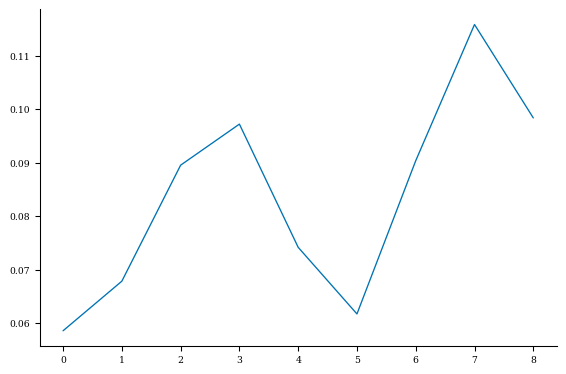

In [333]:
plt.figure()
# plt.plot(crit1)
plt.plot(crit2[1:10])